<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/PerezCoto_Maximiliano_ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1 Introducción

El siguiente cuaderno realiza la norma de N de 3 dimensiones vectores en forma secuencial y parelela utilizando el procesador CPU y GPU respectivamente.

$ {\displaystyle {\vec {V}} = (X_0, Y_0, Z_0)$
<left>$...$</left>

<left>${\vec {V_n}} = (X_n, Y_n, Z_n)$</left>  

<left>Luego,</left>

<left>$||{\vec {V_n}}|| = {\sqrt{( X^2_n + Y^2_n + Z^2_n)}}  $</left>  

El objetivo es calcular la fuerza correspondiente a N vectores para ser utilizado en ambientes de desarrollo gráfico o con fines de investigación científica y además de dejar una plantilla base parametrizable que permita la comparación entre algoritmos secuenciales y paralelos en 1 dimensión utilizando CUDA.

# Armado del Ambiente

A fines de comparar como reacciona el tiempo de ejecución en función de la cantidad de elementos procesados deben pararse como parametros:
1. Vectores: La cantidad de vectores de 3 dimensiones a procesar.
2. Iteraciones: La cantidad de veces que se realiza el proceso, aplicando el multiplicador a los vectores.
3. Multiplicador: Si se eligen 4 vectores y el multiplicador es 2, en cada iteración se incrementarán los vectores por 2.


Por ejemplo, con los valores por defecto se realizarán 5 iteraciones en secuencial y paralelo procesando primero 4 vectores, luego 8, luego 16, luego 32 y finalmente 64, representando los tiempos finales en un gráfico 2D.

## Instalar en el cuaderno el módulo CUDA de Python:

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 5.6MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=de085efcbfc886bb3aae0179f89bdb3e129560796715c3a5e8bdea1670b0c97c
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=c58c7124be70958957232ee00e8a566c5ea153826a8e47e6a46005aa634b3ec0
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# 2 Desarrollo CPU vs GPU

 Tiempo Total CPU:  1.411 [ms]
 Tiempo Total GPU:  0.246 [ms]
 
Eje X: cantidad de vectores
Eje Y: milisegundos


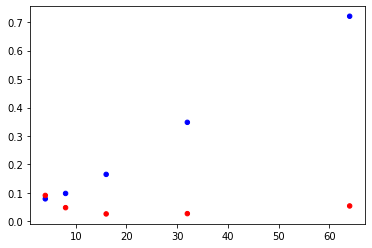

In [4]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución:
#@title cantidad de vectores de 3 dimensiones { vertical-output: true }

vectores = 4#@param {type: "number"}
iteraciones = 5#@param {type: "number"}
multiplicador = 2#@param {type: "number"}

from datetime import datetime
import numpy
import matplotlib.pyplot as plt

try:
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  if vectores < 1:
    raise ValueError("Error: La cantidad de vectores debe ser al menos 1.");
  if multiplicador < 1:
    raise ValueError("Error: El multiplicador de vectores debe ser al menos 1.");
  if iteraciones < 1:
    raise ValueError("Error: La cantidad de itearaciones debe ser al menos 1.");


  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_norm( int n, float *X, float *Y, float *Z, float *V )
  {
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    if( idx < n )
    {
      V[idx] = sqrt(pow(X[idx], 2) + pow(Y[idx], 2) + pow(Z[idx], 2));
    }
  }
  """)
  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_norm")

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  tiempos = []
  colores = []
  cantidades = []
  total_cpu = 0
  total_gpu = 0

  for itx in range(0, iteraciones):
    # CPU - Defino la memoria de los vectores en CPU.
    x_cpu = numpy.random.randn( vectores )
    x_cpu = x_cpu.astype( numpy.float32() )
    y_cpu = numpy.random.randn( vectores )
    y_cpu = y_cpu.astype( numpy.float32() )
    z_cpu = numpy.random.randn( vectores )
    z_cpu = y_cpu.astype( numpy.float32() )
    v_cpu = numpy.empty_like( x_cpu )
    vr_cpu = numpy.empty_like( x_cpu )
    
    # CPU - reservo la memoria GPU.
    x_gpu = cuda.mem_alloc( x_cpu.nbytes )
    y_gpu = cuda.mem_alloc( y_cpu.nbytes )
    z_gpu = cuda.mem_alloc( z_cpu.nbytes )
    v_gpu = cuda.mem_alloc( v_cpu.nbytes )
    # GPU - Copio la memoria al GPU.
    cuda.memcpy_htod( x_gpu, x_cpu )
    cuda.memcpy_htod( y_gpu, y_cpu )
    cuda.memcpy_htod( z_gpu, z_cpu )
    cuda.memcpy_htod( v_gpu, v_cpu )

    # ejecuto el proceso y mido tiempo en CPU
    tiempo_cpu = datetime.now()
    for idx in range( 0, vectores ):
      v_cpu[idx] = numpy.sqrt(pow(x_cpu[idx], 2) + pow(y_cpu[idx], 2) + pow(z_cpu[idx], 2))
    tiempo_cpu = datetime.now() - tiempo_cpu

    # Agrego el resultado de la iteracion para el render
    cantidades.append(vectores)
    colores.append('blue')
    cpu_ms = tiempo_en_ms(tiempo_cpu)
    total_cpu += cpu_ms
    tiempos.append(cpu_ms)

    # ejecuto el proceso y mido tiempo en GPU
    tiempo_gpu = datetime.now()
    dim_hilo = 256
    dim_bloque = numpy.int( (vectores+dim_hilo-1) / dim_hilo )
    kernel( numpy.int32(vectores), x_gpu, y_gpu, z_gpu, v_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )
    tiempo_gpu = datetime.now() - tiempo_gpu
    # GPU - Copio el resultado desde la memoria GPU.
    cuda.memcpy_dtoh( vr_cpu, v_gpu )

    # Agrego el resultado de la iteracion para el render
    cantidades.append(vectores)
    colores.append('red')
    gpu_ms = tiempo_en_ms(tiempo_gpu)
    total_gpu += gpu_ms
    tiempos.append(gpu_ms)

    vectores *= multiplicador

    # Hace lenta la ejecucion pero sirve para chequear que los algoritmos
    # arrojan el mismo resultado
    """
    if v_cpu.all() != vr_cpu.all():
      print( "V-CPU: ", v_cpu )
      print( "V-GPU: ", vr_cpu )
      raise ValueError("Error: El cálculo en secuencial y paralelo arrojan resultados distintos");
    """
  
  # --------------------------------------------

  print("\033[94m Tiempo Total CPU: ", total_cpu, "[ms]" )
  print("\033[91m Tiempo Total GPU: ", total_gpu, "[ms]" )

  print("\033[0m \nEje X: cantidad de vectores")
  print("Eje Y: milisegundos")

  fig, ax = plt.subplots()
  scat = ax.scatter(cantidades, tiempos, c=colores, s=20, vmin=0, vmax=1)


except ModuleNotFoundError:
  print("Error: debe cambiar el entorno a GPU e instalar CUDA en el paso anterior antes de continuar.")
except ValueError as VR:
  print(VR)

---
# 4 Tabla de pasos de ejecución del programa

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param               | Lectura de la cantidad de vectores, multiplicador e iteraciones desde Colab
CPU      |  import                | Importa los módulos para funcionar
CPU      |  try-except            | Se valida la inclusion de los modulos de pycuda y que los parametros sean correctos.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  tiempo_ms:labmda | Se define una función inline que calcula milisegundos
CPU      |  for...iteraciones     | Realiza los procesos CPU vs GPU itx veces
CPU      |  numpy.random.randn(vectores) | Inicializa los vectoes X, Y, Z y V.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  cpu - datetime.now()  | Toma el tiempo inicial en CPU.
CPU      |  for...vectores        | Realiza la norma de los vectores $(X_0, Y_0, Z_0) ... (X_n, Y_n, Z_n) $ , guardando el resultado en $V_n$.
CPU      |  cpu - datetime.now()  | Toma el tiempo final en CPU
CPU      | cantidades, colores, tiempos | Se agregan datos a vectores para el plot de puntos azules de CPU
CPU      |  gpu - datetime.now()  | Toma el tiempo inicial en GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()        | Realiza la norma de los vectores utilizando kernel()
CPU      |  gpu - datetime.now()  | Toma el tiempo final en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU a CPU
CPU      | cantidades, colores, tiempos | Se agregan datos a vectores para el plot de puntos rojos de GPU
CPU      | if v_cpu != vr_cpu | Se verifica que los resultados obtenidos en ambas formas de ejecución coincidan.
CPU      |  print()               | Informa los resultados.
CPU      |  scatter()             | Dibuja un gráfico con los resultados de cantidad de vectores (X) por tiempo de ejecución (Y-ms) en GPU(Rojo) y CPU(Azul)

---
# 5 Conclusiones

La finalización de la ejecución del algoritmo muestra un tiempo total de procesamiento tanto en CPU como en GPU, además de un gráfico de puntos que comparan la cantidad de vectores y tiempo de procesamiento según cada estrategia.
 
Como puede apreciarse en los resultados graficados,  mientras mayor es la cantidad de vectores a los cuales quiere aplicarse el algoritmo, el tiempo de procesamiento en secuencial aumenta exponencialmente, mientras que en paralelo el incremento es muy poco en función de la cantidad de elementos.
En conclusión, la ejecución paralela (en este caso) value la pena ya que disminuye el tiempo de ejecución de manera radical al incrementar la cantidad de datos a procesar.

El resultado del ejercicio no es el algoritmo en sí sino mas bien una buena plantilla para permitir realizar ejecuciones secuenciales vs paralelas y estudiar la comparación entre ambas con incremento de datos y un resultado visual cuantitativo.

### Pasos mas relevantes
1. Reservar memoria en GPU (cuda.mem_alloc).
2. Copiar datos en memoria GPU (cuda.memcpy_htod).
3. Definir la función que va a ejecutar el Kernel.
4. Calcular las dimensiones.
5. Realizar el gráfico.


---

# 6 Bibliografia

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Documentación PyCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[4] Repositorio de PyCUDA: [WEB](https://pypi.python.org/pypi/pycuda)


